In [1]:
import pandas as pd
import requests

pd.set_option('display.max_columns', None)

In [2]:
# Define year range
start_year = 2015
end_year = 2024

years_list = [year for year in range(start_year, end_year+1)]

# Fish Count Data

In [3]:
# Generate URL for defined year range
fish_years = ",".join(map(str, sorted(years_list, reverse=True)))
fish_url = "https://www.adfg.alaska.gov/sf/FishCounts/index.cfm?ADFG=export.JSON&countLocationID=40&year="+fish_years+"&speciesID=420"

# Set User-Agent to mimic browser behavior (without this, the request returns an authentication error)
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
}

# Request data
fish_response = requests.get(fish_url, headers=headers)

# Fetch json if data request is successful
if fish_response.status_code == 200:
    fish_json = fish_response.json()
else:
    print(f"Failed to fetch fish count data: {fish_response.status_code}, {fish_response.text}")

# Read json into dataframe
fish_df = pd.DataFrame(fish_json['DATA'], columns=fish_json['COLUMNS'])
fish_df.head()

,YEAR,COUNTDATE,FISHCOUNT,SPECIESID,COUNTLOCATIONID,COUNTLOCATION,SPECIES
0,2024,"July, 01 2024 00:00:00",6366,420,40,Kenai River (late-run sockeye),Sockeye
1,2024,"July, 02 2024 00:00:00",5484,420,40,Kenai River (late-run sockeye),Sockeye
2,2024,"July, 03 2024 00:00:00",9630,420,40,Kenai River (late-run sockeye),Sockeye
3,2024,"July, 04 2024 00:00:00",13590,420,40,Kenai River (late-run sockeye),Sockeye
4,2024,"July, 05 2024 00:00:00",18120,420,40,Kenai River (late-run sockeye),Sockeye


In [4]:
fish_df.describe(include='all')

,YEAR,COUNTDATE,FISHCOUNT,SPECIESID,COUNTLOCATIONID,COUNTLOCATION,SPECIES
count,528.000000,528,528.000000,528.0,528.0,528,528
unique,NaN,528,NaN,NaN,NaN,1,1
top,NaN,"August, 26 2015 00:00:00",NaN,NaN,NaN,Kenai River (late-run sockeye),Sockeye
freq,NaN,1,NaN,NaN,NaN,528,528
mean,2019.376894,NaN,32741.606061,420.0,40.0,NaN,NaN
std,2.831109,NaN,28706.330094,0.0,0.0,NaN,NaN
min,2015.000000,NaN,1436.000000,420.0,40.0,NaN,NaN
25%,2017.000000,NaN,13990.500000,420.0,40.0,NaN,NaN
50%,2019.000000,NaN,25421.500000,420.0,40.0,NaN,NaN
75%,2022.000000,NaN,41381.000000,420.0,40.0,NaN,NaN


In [5]:
# drop unneeded columns and rename remaining columns
fish_df = (
    fish_df.drop(columns=['SPECIESID','COUNTLOCATIONID','COUNTLOCATION','SPECIES'])
    .rename(columns={
        'YEAR': 'year',
        'COUNTDATE': 'date',
        'FISHCOUNT': 'fish_count',
    })
)

fish_df.head()

,year,date,fish_count
0,2024,"July, 01 2024 00:00:00",6366
1,2024,"July, 02 2024 00:00:00",5484
2,2024,"July, 03 2024 00:00:00",9630
3,2024,"July, 04 2024 00:00:00",13590
4,2024,"July, 05 2024 00:00:00",18120


In [23]:
fish_df['date'] = pd.to_datetime(fish_df['date'])

# Water temperature and discharge rate data

Water data is retrieved using the USGS's data retrieval package.

<u>Documentation</u>: https://github.com/DOI-USGS/dataretrieval-python

<u>Available parameters</u>: https://waterdata.usgs.gov/nwis/dv/?site_no=15266300&agency_cd=USGS&amp;referred_module=sw

In [6]:
import dataretrieval.nwis as nwis

# specify the Kenai River site (Soldotna, AK)
site_no = '15266300'

# define start and end dates
start_date = f"{start_year}-01-01"
end_date = f"{end_year}-12-31"

In [7]:
# confirm site info
site_info = nwis.get_info(sites=site_no)
site_info[0]

,agency_cd,site_no,station_nm,site_tp_cd,lat_va,long_va,dec_lat_va,dec_long_va,coord_meth_cd,coord_acy_cd,coord_datum_cd,dec_coord_datum_cd,district_cd,state_cd,county_cd,country_cd,land_net_ds,map_nm,map_scale_fc,alt_va,alt_meth_cd,alt_acy_va,alt_datum_cd,huc_cd,basin_cd,topo_cd,instruments_cd,construction_dt,inventory_dt,drain_area_va,contrib_drain_area_va,tz_cd,local_time_fg,reliability_cd,gw_file_cd,nat_aqfr_cd,aqfr_cd,aqfr_type_cd,well_depth_va,hole_depth_va,depth_src_cd,project_no
0,USGS,15266300,KENAI R AT SOLDOTNA AK,ST,602839,1510446,60.476929,-151.081668,M,T,NAD27,NAD83,2,2,122,US,NESWSWS32 T005N R010W S,KENAI B-3NW,25000,40.4,F,0.01,NAVD88,19020302,NaN,NaN,NNNNYNNNNNNNNNNNNNNNNNNNNNNNNN,NaN,NaN,2020,NaN,AKST,Y,NaN,NYNNNNNN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# define function to generate dataframe for a given parameter
def fetch_water_data(parameter):
    water_data = nwis.get_dv(
        sites=site_no,
        start=start_date,
        end=end_date,
        parameterCd=parameter
    )
    return water_data[0]

### Water Temperature Data

In [9]:
# fetch daily water temperature data
water_temp_df = fetch_water_data("00010") # 00010 = water temp (celsius)
water_temp_df.head()

,site_no,00010_Maximum,00010_Maximum_cd,00010_Minimum,00010_Minimum_cd,00010_Mean,00010_Mean_cd
datetime,,,,,,,
2015-01-01 00:00:00+00:00,15266300,2.4,A,1.7,A,2.2,A
2015-01-02 00:00:00+00:00,15266300,1.7,A,0.4,A,0.8,A
2015-01-03 00:00:00+00:00,15266300,0.4,A,0.0,A,0.3,A
2015-01-04 00:00:00+00:00,15266300,0.0,A,0.0,A,0.0,A
2015-01-05 00:00:00+00:00,15266300,0.0,A,0.0,A,0.0,A


In [10]:
# drop unneeded columns, reset index, and rename remaining columns
water_temp_df = (
    water_temp_df.drop(columns=['site_no','00010_Maximum_cd','00010_Minimum_cd','00010_Mean_cd'])
    .reset_index()
    .rename(columns={
        'datetime': 'date',
        '00010_Maximum': 'water_temp_max',
        '00010_Minimum': 'water_temp_min',
        '00010_Mean': 'water_temp_mean',
    })
)

water_temp_df.head()

,date,water_temp_max,water_temp_min,water_temp_mean
0,2015-01-01 00:00:00+00:00,2.4,1.7,2.2
1,2015-01-02 00:00:00+00:00,1.7,0.4,0.8
2,2015-01-03 00:00:00+00:00,0.4,0.0,0.3
3,2015-01-04 00:00:00+00:00,0.0,0.0,0.0
4,2015-01-05 00:00:00+00:00,0.0,0.0,0.0


### Water Discharge Data

In [11]:
# fetch daily water temperature data
water_discharge_df = fetch_water_data("00060") # 00060 = discharge (cubic feet per second)
water_discharge_df.head()

,site_no,00060_Mean,00060_Mean_cd
datetime,,,
2015-01-01 00:00:00+00:00,15266300,2580.0,A
2015-01-02 00:00:00+00:00,15266300,2490.0,A
2015-01-03 00:00:00+00:00,15266300,2390.0,A
2015-01-04 00:00:00+00:00,15266300,2370.0,"A, e"
2015-01-05 00:00:00+00:00,15266300,2350.0,"A, e"


In [12]:
# drop unneeded columns, reset index, and rename remaining columns
water_discharge_df = (
    water_discharge_df.drop(columns=['site_no','00060_Mean_cd'])
    .reset_index()
    .rename(columns={
        'datetime': 'date',
        '00060_Mean': 'water_discharge_mean',
    })
)

water_discharge_df.head()

,date,water_discharge_mean
0,2015-01-01 00:00:00+00:00,2580.0
1,2015-01-02 00:00:00+00:00,2490.0
2,2015-01-03 00:00:00+00:00,2390.0
3,2015-01-04 00:00:00+00:00,2370.0
4,2015-01-05 00:00:00+00:00,2350.0


In [13]:
# join water dataframes
water_df = pd.merge(water_temp_df, water_discharge_df, on='date', how='outer')
water_df.head()

,date,water_temp_max,water_temp_min,water_temp_mean,water_discharge_mean
0,2015-01-01 00:00:00+00:00,2.4,1.7,2.2,2580.0
1,2015-01-02 00:00:00+00:00,1.7,0.4,0.8,2490.0
2,2015-01-03 00:00:00+00:00,0.4,0.0,0.3,2390.0
3,2015-01-04 00:00:00+00:00,0.0,0.0,0.0,2370.0
4,2015-01-05 00:00:00+00:00,0.0,0.0,0.0,2350.0


In [29]:
water_df['date'] = pd.to_datetime(water_df['date'])

# Water level/tidal data

<u>NOAA water level data</u>:
<br>https://tidesandcurrents.noaa.gov/waterlevels.html?id=9455760

<u>NOAA API documentation</u>:
<br>https://tidesandcurrents.noaa.gov/web_services_info.html
<br>https://api.tidesandcurrents.noaa.gov/api/prod/
<br><a href="https://github.com/NOAA-CO-OPS/Coastal_Hazards_Example_Notebooks/blob/main/CO-OPS_API_Example_Notebook_HurricaneIan/CO-OPS_API_Example_Notebook_HurricaneIan.ipynb">Example notebook for data retrieval via CO-OPS API</a>
<br><a href="https://tidesandcurrents.noaa.gov/datum_options.html">Datum options</a>

In [14]:
# # NOAA's station in Nikiski, AK is the nearest to the Kenai River mouth
# noaa_station_id = '9455760'
# time_zone = 'lst'
# datum = 'MSL'
# units = 'english'
# # start_date = str(start_year) + '0101'
# # end_date = str(end_year) + '1231'
# start_date = '20241201'
# end_date = '20241231'

# noaa_api = 'https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?begin_date='+start_date+'&end_date='+end_date+'&station='+noaa_station_id+'&product=water_level&datum='+datum+'&time_zone='+time_zone+'&units='+units+'&format=json#api'

In [15]:
from datetime import datetime

# Parameters
noaa_station_id = '9455760'
time_zone = 'lst'
datum = 'MSL' # mean sea level (see link above for dataum options)
language = 'english'

In [16]:
# Function to retrieve and process NOAA data for a set date
# If API request is successful, this function returns data in a list (which can be appended with a loop)

import numpy as np

def fetch_daily_sea_levels(month_start):
    # Format the start and end date for the API request
    start_date_str = month_start.strftime('%Y%m%d')
    end_date_str = (month_start + pd.offsets.MonthEnd(0)).strftime('%Y%m%d')
    
    # Construct the NOAA API URL
    noaa_api = f'https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?begin_date={start_date_str}&end_date={end_date_str}&station={noaa_station_id}&product=water_level&datum={datum}&time_zone={time_zone}&units={language}&format=json'
    
    # Request data from NOAA
    noaa_response = requests.get(noaa_api)
    
    if noaa_response.status_code == 200:
        data = []
        noaa_json = noaa_response.json()
        # Extract the water level data (for the current day)
        for record in noaa_json['data']:
            sea_level_value = record['v']
            data.append({
                'timestamp': record['t'],
                'sea_level': float(sea_level_value) if sea_level_value else np.nan # if/else is needed because some values are ''
            })
        return data
    else:
        print(f"Failed to fetch NOAA data for month ending {month_start + pd.offsets.MonthEnd(0)}: {noaa_response.status_code}, {noaa_response.text}")
        return None

In [17]:
# List to store results
sea_level_df = pd.DataFrame({
    'date': [],
    'min': [],
    'max': []
})

# Start of month date for the loop
current_month = datetime(start_year, 1, 1)

while current_month <= datetime(end_year, 12, 1):
    current_month_data = fetch_daily_sea_levels(current_month)
    current_month_df = pd.DataFrame(current_month_data)
    
    current_month_df['date'] = pd.to_datetime(current_month_df['timestamp'])
    current_month_df = current_month_df.groupby(current_month_df['date'].dt.date)['sea_level'].agg(['min','max']).reset_index()
    
    sea_level_df = pd.concat([sea_level_df, current_month_df], ignore_index=True)
    # print(current_month) # DELETE THIS LINE AFTER DEBUGGING
    current_month = current_month + pd.DateOffset(months=1)

In [18]:
sea_level_df['date'] = pd.to_datetime(sea_level_df['date'])

In [19]:
# missing data on 49 different days between 5/18/20 - 10/14/20
nan_rows = sea_level_df[sea_level_df.isna().any(axis=1)]
nan_rows.describe()

,date,min,max
count,49,0.0,0.0
mean,2020-07-22 05:52:39.183673344,NaN,NaN
min,2020-05-18 00:00:00,NaN,NaN
25%,2020-06-10 00:00:00,NaN,NaN
50%,2020-06-22 00:00:00,NaN,NaN
75%,2020-10-02 00:00:00,NaN,NaN
max,2020-10-14 00:00:00,NaN,NaN
std,NaN,NaN,NaN


<Axes: xlabel='date'>

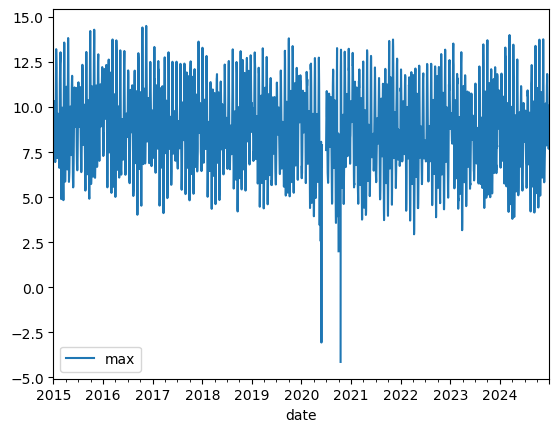

In [22]:
import matplotlib.pyplot as plt

sea_level_df.plot(x='date', y='max')

# Save Raw Data to .csv Files

In [42]:
# Save data to csv files

folder_path = '../data/raw_data/'

# fish count data
fish_file_name = f'{start_year}-{end_year}_fish_data_raw.csv'
fish_df.to_csv(folder_path + fish_file_name, index=False)

# water temperature data
water_temp_file_name = f'{start_year}-{end_year}_water_temp_data_raw.csv'
water_df.to_csv(folder_path + water_temp_file_name, index=False)

# sea level/tidal data
sea_level_file_name = f'{start_year}-{end_year}_sea_level_data_raw.csv'
sea_level_df.to_csv(folder_path + sea_level_file_name, index=False)

In [39]:
!where python

C:\Users\tyler\anaconda3\envs\kenai-salmon-env\python.exe
C:\Users\tyler\AppData\Local\Microsoft\WindowsApps\python.exe
C:\Users\tyler\Anaconda3\python.exe


In [40]:
import sys
print(sys.executable)

C:\Users\tyler\anaconda3\envs\kenai-salmon-env\python.exe
